In [1]:
import sys
sys.path.append("../../")

from astronn import datasets
from astronn import models

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Stra model to train
star_models = datasets.starmodels()
df = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=150)
# Read datasets of preprocessed real stars to test
df_ds = datasets.deltascuti()
deltascuti = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)
ds_stars = [star for star in deltascuti.take(11)]

Using TensorFlow backend.


In [2]:
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath="/tmp/model_checkpoint",
#    save_weights_only=True,
#    monitor='val_acc',
#    mode='max',
#    save_best_only=True)

In [3]:
results = {}
results["loss"] = []
higher_n_probs = 10
loops = 1
for loop in range(loops):
    print("Loop %s" % loop)
    sepconv_mod = models.separableconvnn() #init model
    sepconv_mod.compile(learning_rate=0.0001) # compile model
    for ep in range(100):
        history = sepconv_mod.model.fit(df, steps_per_epoch=50, epochs=1)
        sepconv_mod.save("/tmp/sepconvnn_tmp_%s" % ep) # tmp model save
        # Add prediction
        for star in ds_stars:
            if star[0].numpy()[0].decode("utf-8") not in results:
                results[star[0].numpy()[0].decode("utf-8")] = {}
            #results[star[0].numpy()[0].decode("utf-8")].append(sepconv_mod.model.predict_classes(star[1]))
            probs = sepconv_mod.model.predict_proba(star[1]).ravel()
            for idx, val in np.ndenumerate(probs.argsort()[-higher_n_probs:][::-1]):
                if idx not in results[star[0].numpy()[0].decode("utf-8")]:
                    results[star[0].numpy()[0].decode("utf-8")][idx] = []
                results[star[0].numpy()[0].decode("utf-8")][idx].append(val)
        results["loss"].append(history.history['loss'][0])

Loop 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 199, 10)           310       
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 95, 10)            1010      
_________________________________________________________________
average_pooling1d (AveragePo (None, 47, 10)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 10)            40        
_________________________________________________________________
dropout (Dropout)            (None, 47, 10)            0         
_________________________________________________________________
flatten (Flatten)            (None, 470)               0         
_________________________________________________________________
dense (Dense)                (None, 100)         

dict_keys(['loss', 'KIC9851944', 'CID105906206', 'kic10661783', 'HD159561', 'CID100866999', 'HD15082', 'HD172189', 'KIC3858884', 'KIC10080943', 'kic4544587', 'KIC8262223'])

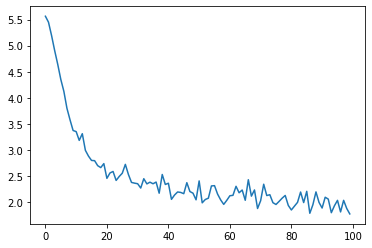

In [14]:
plt.plot(results["loss"])

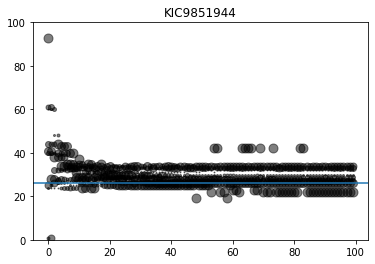

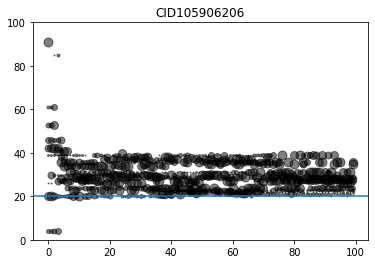

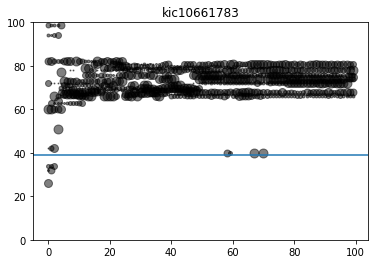

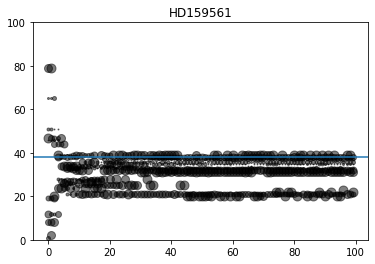

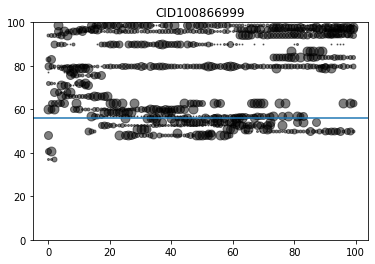

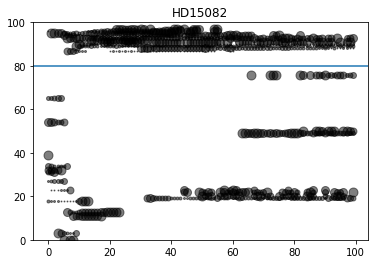

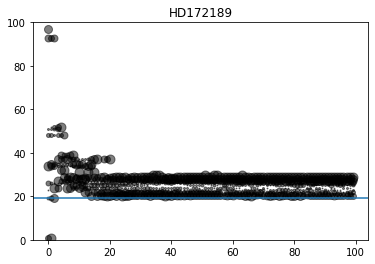

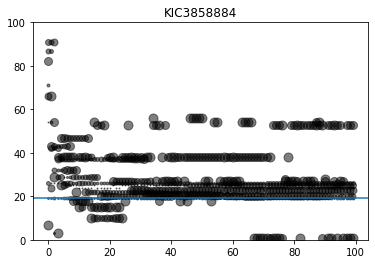

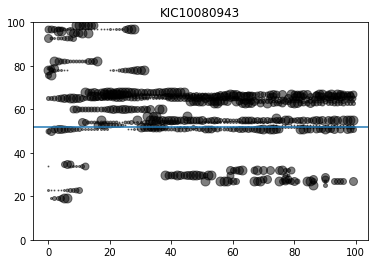

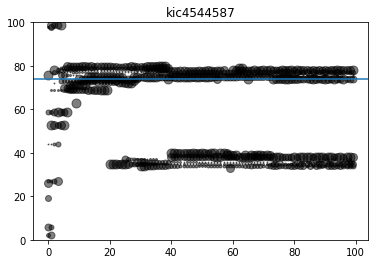

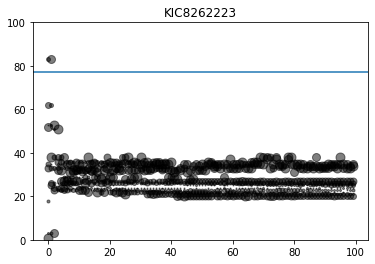

In [7]:
targets = {}
targets["kic10661783"] = {"dnu": 39.0, "dr": 7.0}
targets["KIC9851944"] = {"dnu": 26.0, "dr": 5.3}
targets["HD159561"] = {"dnu": 38.0, "dr": 19.0}
targets["CID100866999"] = {"dnu": 56, "dr": np.nan}
targets["HD15082"] = {"dnu": 80.0, "dr": 14.0}
targets["kic4544587"] = {"dnu": 74.0, "dr": 11.0}
targets["KIC8262223"] = {"dnu": 77.0, "dr": 7.10}
targets["HD172189"] = {"dnu": 19.0, "dr": 4.6}
targets["KIC3858884"] = {"dnu": 19.0, "dr": 1.9}
targets["CID105906206"] = {"dnu": 20.0, "dr": 2.61}
targets["KIC10080943"] = {"dnu": 52.0, "dr": 1.7}

for star in results.keys():
    if star in targets.keys():
        for idx, val in enumerate(range(higher_n_probs)):
            plt.plot(results[star][(val,)], alpha=0.5, marker='o', linestyle='None', color="black", markersize=idx)
        plt.axhline(y=targets[star]["dnu"])
        plt.title(star)
        plt.ylim(0, 100)
        plt.show()